In [1]:
from lbc.models import *
from lbc.utils import *
from lbc.datasets import *
from lbc.plots import *

from lbc.train_cnn import train


In [3]:
if __name__ == "__main__":
    cf = AttrDict() # Describes all the 'knobs' of an experiment
    cf.seeds = [42]  # List of seeds for reproducibility

    # TRAINING
    cf.epochs = 10
    cf.learning_rate = 1e-3
    cf.weight_decay = 1e-5        # L2 regularization on weights
    cf.patience = 10              # early stopping patience, in epochs
    cf.init = "kaiming"           # weight initialization method, only "kaiming" is implemented so far

    # DATASET
    cf.dataset = "XXZ"
    cf.label_param = "Jz"      # label parameter for the Paris datasets; 't', 'delta', 'omega' for Ising, 't' for XY, 'beta' for ILGT
    cf.normalize_labels = True    # normalize labels to [0, 1] range, only for regression
    cf.kernels = None

    cf.model = "simple_cnn"
    cf.task = "lbc"
    cf.data_fraction = 1       # fraction of data to use for training+validation

In [ ]:
no_partitions = get_no_partitions(cf)
assert no_partitions is not None, "The number of partitions cannot be None."
cf.train_dataset, cf.val_dataset = create_datasets(cf)   # deterministic; train-val split uses a separate seed.
set_plotting_logging_strings(cf)

metrics_per_seed = {}
for seed in cf.seeds:
    cf.seed = seed
    metrics_per_partition = {"z":[], f"val_{cf.loss_str}":[], f"train_{cf.loss_str}":[],
                        f"val_{cf.goodness_str}":[], f"train_{cf.goodness_str}":[]}
    for partition_index in range(no_partitions):
        cf.partition_index = partition_index
        cf.train_dataset, cf.val_dataset = create_datasets(cf)   # deterministic; train-val split uses a separate seed.

        cf.logdir = f"logs/lbc_{cf.dataset}/seed_{cf.seed}/partition_{cf.partition_index}"
        train(cf, "metrics.json") 

        metrics = load_json(cf.logdir, "metrics.json")

        plot_history(metrics, cf, "history.png")
        update_metrics_per_partition(cf, metrics, metrics_per_partition)

    metrics_per_seed[seed] = metrics_per_partition

cf.logdir = f"logs/lbc_{cf.dataset}"
save_json(metrics_per_seed, cf.logdir, "metrics_per_seed.json")

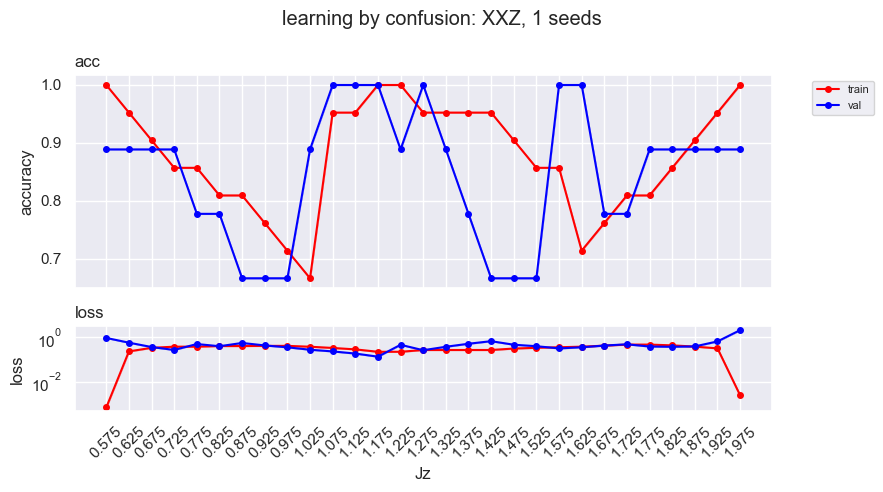

In [7]:
cf.logdir = f"logs/lbc_{cf.dataset}"
metrics_per_seed = load_json(cf.logdir, "metrics_per_seed.json")
plot_lbc(metrics_per_seed, cf, "lbc_summary.png",show=True)